In [1]:
using SparseArrays, Plots
include("../code/matrix_generator.jl")

valid_degrees (generic function with 2 methods)

In [2]:
function leaf_removal(H::SparseMatrixCSC, Ht = sparse(transpose(H)))
    M, N = size(H)
    degs = vec(sum(H .!= 0, dims=1))
    facts = fill(true, M)
    rowperm = Int[]
    Q = findall(degs .== 1)
    indep = findall(degs .== 0)
    dep = Int[]
    while !isempty(Q)
        # # introduce some randomness
        # L = length(Q)
        # if L > 1
        #     r = rand(2:L)
        #     Q[1], Q[r] = Q[r], Q[1]
        # end
        i = popfirst!(Q)
        degs[i] == 0 && continue
        push!(dep, i)
        ∂i1 = @view rowvals(H)[nzrange(H,i)]
        ∂i = ∂i1[facts[∂i1]]
        @assert length(∂i) == 1 # should be a residual leaf
        a = ∂i[1]
        facts[a] = false
        push!(rowperm, a) 
        for j in @view rowvals(Ht)[nzrange(Ht,a)]
            degs[j] -= 1
            if j != i
                if degs[j] == 0
                    push!(indep, j)
                elseif degs[j] == 1
                    push!(Q, j)
                end
            end
        end
    end
    all(degs .==  0) || @warn "non-empty core"
    rowperm, [dep; indep]
end

leaf_removal (generic function with 2 methods)

In [3]:
isuppertriang(H::SparseMatrixCSC) = all(rowvals(H)[last(nzrange(H,i))] == i for i = 1:size(H,1))

isuppertriang (generic function with 1 method)

In [4]:
# THE OLD ONE
function ut2diagGF2!(T::SparseMatrixCSC)
    (m,n) = size(T)
    # Check that the left part of T is unit upper triangular
    @assert isuppertriang(T)
    # Loop over diagonal elements
    for c in m:-1:2
        # Find non-zero elements above T[c,c] and perform row operations to 
        #  cancel them out
        for (j,v) in @views zip(rowvals(T[:,c]),nonzeros(T[:,c]))
            if v != 0 && j < c
                for k in rowvals(T[c,c:end]).+c.-1
                    T[j,k] ⊻= T[c,k]
                end
            end
        end
    end
    dropzeros!(T)
end

ut2diagGF2! (generic function with 1 method)

In [5]:
# THE NEW ONE
function ut2diagGF2(T::SparseMatrixCSC)
    (m,n) = size(T)
    @assert isuppertriang(T)
    # Store the rows of the right part in a vector of sparse vectors
    Tt = sparse(T')
    R = [Tt[m+1:end,r] for r in 1:m]
    # Loop over diagonal elements
    for c in m:-1:2
        # Loop over the elements above T[c,c]
        for j in @view rowvals(T)[nzrange(T,c)]
            if j < c
                # R[j] .⊻= R[c]
                for k in rowvals(R[c])
                    R[j][k] = !R[j][k]
                end
            end
        end
    end
    # U = sparse(reduce(hcat,R)')
end

ut2diagGF2 (generic function with 1 method)

In [6]:
function degree2_mat(N)
    f1 = 0.0
    N1 = Int(N*f1)
    Q = mod1(sum(digits(2N-N1)),3)
    N1 = N1 + Q
    N2 = N - N1
    nedges = (N1+2N2)
    M = Int(nedges/3)
    Lambda = [N1, N2] / N
    @assert sum(Lambda)==1
    Rho = [0,0,1]
    Ht = ldpc_matrix(N, M, nedges, Lambda, Rho, accept_multi_edges=false)
    H = sparse(Ht')
    H,Ht
end

degree2_mat (generic function with 1 method)

Build graphs of increasing size with $f_2=1$

In [9]:
Ns = round.(Int, 10 .^ (3:0.3:4.5))
times_old = zeros(length(Ns))
times_new = zeros(length(Ns))
for (i,N) in pairs(Ns)
    println("## Size $i of ", length(Ns), ": N=$N")
    H,Ht = degree2_mat(N)
    rowperm, colperm = leaf_removal(H, Ht)
    Hnew = H[rowperm, colperm]
    t = @timed ut2diagGF2!(copy(Hnew))
    times_old[i] = t[2]
    t = @timed ut2diagGF2(Hnew)
    times_new[i] = t[2]
end

## Size 1 of 6: N=1000
## Size 2 of 6: N=1995
## Size 3 of 6: N=3981
## Size 4 of 6: N=7943
## Size 5 of 6: N=15849
## Size 6 of 6: N=31623


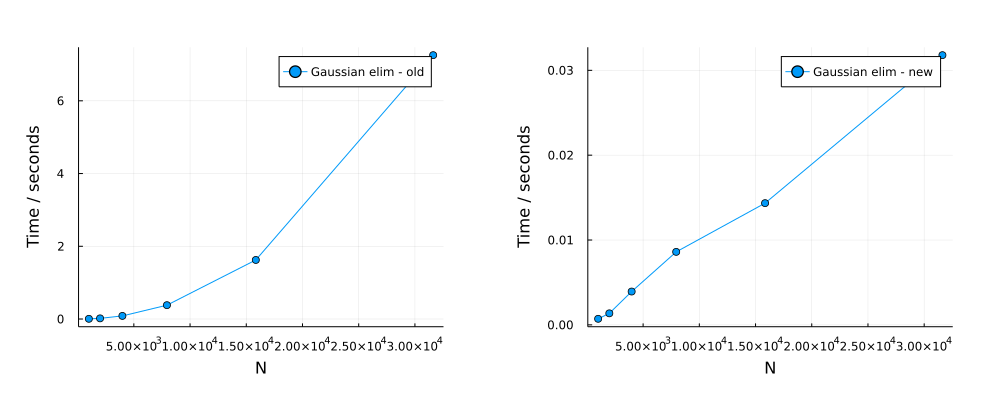

In [10]:
p1 = plot(Ns, times_old, marker=:circle, label="Gaussian elim - old", xlabel="N", ylabel="Time / seconds")
p2 = plot(Ns, times_new, marker=:circle, label="Gaussian elim - new", xlabel="N", ylabel="Time / seconds")
plot(p1,p2, size=(1000,400), margins=10Plots.mm)

The complete function to build a basis is
`[1] findbasis(H) in Main at /home/crotti/sourcecoding/code/slim_graphs.jl:120`